In [1]:
!gdown 1y8xhCM_rVCgxOPSF3VtVkFxnwxtBlH0x

Downloading...
From (original): https://drive.google.com/uc?id=1y8xhCM_rVCgxOPSF3VtVkFxnwxtBlH0x
From (redirected): https://drive.google.com/uc?id=1y8xhCM_rVCgxOPSF3VtVkFxnwxtBlH0x&confirm=t&uuid=ffc6e644-f5d2-452b-836d-fe5d75e32bb5
To: /content/adopt.py
100% 18.3k/18.3k [00:00<00:00, 36.9MB/s]


## Load Data

In [ ]:
import torch
from torch import nn
from adopt import ADOPT
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import numpy as np
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [ ]:
batch_size = 512
num_epochs = 300
lr = 0.001

In [ ]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 177kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.32MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.9MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Modeling

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = self.sigmoid(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        x = self.layer4(x)
        x = self.sigmoid(x)
        x = self.layer5(x)
        x = self.sigmoid(x)
        out = self.output(x)
        return out

In [ ]:
model = MLP(input_dims=784, hidden_dims=128, output_dims=10).to(device)
criterion = nn.CrossEntropyLoss()

# link paper: https://arxiv.org/abs/2411.02853
optimizer = ADOPT(model.parameters(), lr=lr)

## ADOPT

In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []
for epoch in range(num_epochs):
    model.train()
    t_loss = 0
    t_acc = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    t_loss /= len(train_loader)
    train_losses.append(t_loss)
    t_acc /= cnt
    train_acc.append(t_acc)

    model.eval()
    v_loss = 0
    v_acc = 0
    cnt = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            v_loss += loss.item()
            v_acc += (torch.argmax(outputs, 1)==y).sum().item()
            cnt += len(y)
    v_loss /= len(test_loader)
    val_losses.append(v_loss)
    v_acc /= cnt
    val_acc.append(v_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {t_loss:.4f}, Train_Acc: {t_acc:.4f}, Validation Loss: {v_loss:.4f}, Val_Acc: {v_acc:.4f}")

Epoch 1/300, Train_Loss: 2.3577, Train_Acc: 0.0992, Validation Loss: 2.3029, Val_Acc: 0.1000
Epoch 2/300, Train_Loss: 2.3028, Train_Acc: 0.1000, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 3/300, Train_Loss: 2.3027, Train_Acc: 0.1000, Validation Loss: 2.3026, Val_Acc: 0.1000
Epoch 4/300, Train_Loss: 2.3027, Train_Acc: 0.0990, Validation Loss: 2.3026, Val_Acc: 0.1000
Epoch 5/300, Train_Loss: 2.3027, Train_Acc: 0.0989, Validation Loss: 2.3026, Val_Acc: 0.1000
Epoch 6/300, Train_Loss: 2.3026, Train_Acc: 0.0992, Validation Loss: 2.3026, Val_Acc: 0.1000
Epoch 7/300, Train_Loss: 2.3027, Train_Acc: 0.0992, Validation Loss: 2.3026, Val_Acc: 0.1000
Epoch 8/300, Train_Loss: 2.3026, Train_Acc: 0.0983, Validation Loss: 2.3026, Val_Acc: 0.1000
Epoch 9/300, Train_Loss: 2.3027, Train_Acc: 0.0970, Validation Loss: 2.3026, Val_Acc: 0.1000
Epoch 10/300, Train_Loss: 2.3026, Train_Acc: 0.0999, Validation Loss: 2.3026, Val_Acc: 0.1000
Epoch 11/300, Train_Loss: 2.3026, Train_Acc: 0.0981, Validation Loss:

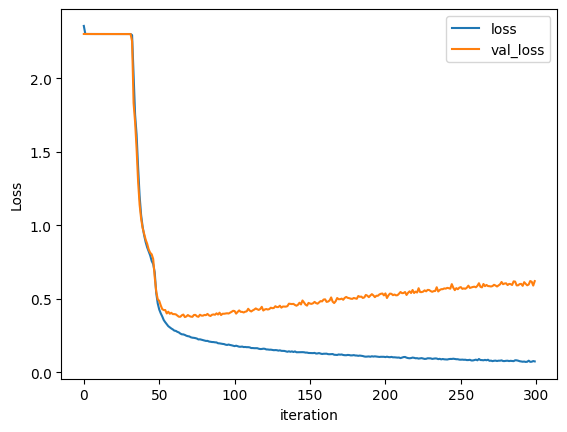

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

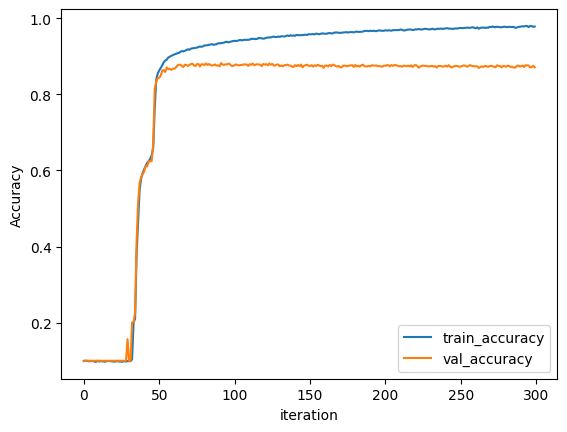

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()